In [1]:
import sys
sys.path.insert(0,'..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import torch

from patchify import patchify, unpatchify

c:\Users\belav\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\belav\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\belav\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
torch.cuda.is_available()

True

In [4]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import numpy as np
from torch.nn import init

### Weight Initialization ###

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

### Utility Layer ###

class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, conv_depth=2, conv_kernel_size=3, conv_stride=1, conv_padding=1):
        super(ConvBlock, self).__init__()
        self.n = conv_depth
        self.ks = conv_kernel_size
        self._stride = conv_stride
        self.padding = conv_padding
        if is_batchnorm:
            for i in range(1, self.n + 1):
                conv = nn.Sequential(nn.Conv2d(in_channels=in_size,out_channels=out_size,kernel_size=self.ks,
                                               stride=self._stride,padding=self.padding),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size
        else:
            for i in range(1, self.n + 1):
                conv = nn.Sequential(nn.Conv2d(in_channels=in_size,out_channels=out_size,kernel_size=self.ks,
                                               stride=self._stride,padding=self.padding),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

### Actual Unet3+ ###

'''
    UNet 3+ with deep supervision and class-guided module
'''
class UNet_3Plus_DeepSup_CGM(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, start_neurons:int = 32, is_batchnorm=True, conv_depth=2, conv_kernel_size=3, conv_stride=1, conv_padding=1):
        super(UNet_3Plus_DeepSup_CGM, self).__init__()
        self.feature_scale = feature_scale

        filters = [feature_scale*start_neurons*i for i in range(1,5)]
        print(filters)

        ## -------------Encoder--------------

        self.conv1 = ConvBlock(in_channels, filters[0], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = ConvBlock(filters[0], filters[1], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = ConvBlock(filters[1], filters[2], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = ConvBlock(filters[2], filters[3], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 4
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # # h1->320*320, hd4->40*40, Pooling 8 times
        # self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        # self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        # self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        # self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(filters[-1], self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # # h1->320*320, hd3->80*80, Pooling 4 times
        # self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        # self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        # self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        # self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        # self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        # self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        # self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        # self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # '''stage 1d'''
        # # h1->320*320, hd1->320*320, Concatenation
        # self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        # self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        # self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # # hd2->160*160, hd1->320*320, Upsample 2 times
        # self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        # self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        # self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        # self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # # hd3->80*80, hd1->320*320, Upsample 4 times
        # self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        # self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        # self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        # self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # # hd4->40*40, hd1->320*320, Upsample 8 times
        # self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        # self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        # self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        # self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # # hd5->20*20, hd1->320*320, Upsample 16 times
        # self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        # self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        # self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        # self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        # self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        # self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        # self.relu1d_1 = nn.ReLU(inplace=True)

        # -------------Bilinear Upsampling--------------
        #self.upscore6 = nn.Upsample(scale_factor=32,mode='bilinear')###
        self.upscore4 = nn.Upsample(scale_factor=8,mode='bilinear')
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear')
        self.upscore2 = nn.Upsample(scale_factor=2,mode='bilinear')
        self.upscore1 = nn.Upsample(scale_factor=1, mode='bilinear')

        # DeepSup
        #self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv2 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv3 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv4 = nn.Conv2d(filters[-1], n_classes, 3, padding=1)

        self.cls = nn.Sequential(
                    nn.Dropout(p=0.5),
                    nn.Conv2d(filters[-1], 2, 1),
                    nn.AdaptiveMaxPool2d(1),
                    nn.Sigmoid())

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def dotProduct(self,seg,cls):
        B, N, H, W = seg.size()
        seg = seg.view(B, N, H * W)
        final = torch.einsum("ijk,ij->ijk", [seg, cls])
        final = final.view(B, N, H, W)
        return final

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        hd4 = self.conv4(h4)  # h4->40*40*512

        # -------------Classification-------------
        cls_branch = self.cls(hd4).squeeze(3).squeeze(2)  # (B,N,1,1)->(B,N)
        cls_branch_max = cls_branch.argmax(dim=1)
        cls_branch_max = cls_branch_max[:, np.newaxis].float()

        ## -------------Decoder-------------
        # h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        # h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        # h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        # h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        # hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        # hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
        #     torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        #hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        #hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        #hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1), 1)))) # hd1->320*320*UpChannels

        # d5 = self.outconv5(hd5)
        # d5 = self.upscore5(d5) # 16->256

        d4 = self.outconv4(hd4)
        d4 = self.upscore4(d4) # 32->256

        d3 = self.outconv3(hd3)
        d3 = self.upscore3(d3) # 64->256

        d2 = self.outconv2(hd2)
        d2 = self.upscore2(d2) # 128->256

        d1 = self.outconv1(hd1) # 256

        d1 = self.dotProduct(d1, cls_branch_max)
        d2 = self.dotProduct(d2, cls_branch_max)
        d3 = self.dotProduct(d3, cls_branch_max)
        d4 = self.dotProduct(d4, cls_branch_max)
        #d5 = self.dotProduct(d5, cls_branch_max)

        return torch.nn.Identity()(d1), torch.nn.Identity()(d2),torch.nn.Identity()(d3),torch.nn.Identity()(d4) #, torch.sigmoid(d5)

In [5]:
#net = UNet_3Plus_DeepSup_CGM(in_channels=1, n_classes=3, feature_scale=2, start_neurons = 16, is_batchnorm=True, conv_depth=2, conv_kernel_size=3, conv_stride=1, conv_padding=1)

In [5]:
import os
import random
import torch
import datetime

from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm.auto import tqdm, trange
from Unet_torch import *

torch.backends.cudnn.benchmark = True

unet = UNet(in_channels = 1,
           num_fmaps = 32,
           fmap_inc_factors = 3,
           downsample_factors = [[2,2],[2,2],[2,2],[2,2]],
           activation = 'ReLU',
           padding= "same")

final_conv = torch.nn.Conv2d(
    in_channels=32,
    out_channels=3,
    kernel_size=1,
    padding='same')

net = torch.nn.Sequential(unet, final_conv)

device = torch.device("cuda")

net = net.to(device)

#net.load_state_dict(torch.load('./model/IPHT_test/model_best.pt'))
#net.load_state_dict(torch.load('C:/MBL/model/WU_1/model_best.pt'))
#net.load_state_dict(torch.load('../../Outer/model/Unet_classical_MeanNorm/final_5000_norm.pt'))

In [7]:
#net.load_state_dict(torch.load('C:/wuerzburg/model/256_4000_tilt_just_post_1_ES_cont/model_current.pt'))
#net.load_state_dict(torch.load('C:/MBL/model/WU_1/model_best.pt'))
#net.load_state_dict(torch.load('C:/wuerzburg/model/256_4000_tilt_post_1/final.pt'))

In [8]:
#net.load_state_dict(torch.load('../../../Paper Prep/models/paperPrep_Shareloc_8_autobatch_identity_last_norm722/save_4000.pt')) # normalization

In [9]:
#net.load_state_dict(torch.load('../../../Paper Prep/models/paperPrep_Wuerzburg_1_autobatch_identity_last_norm725/model_best.pt'))

In [10]:
#net.load_state_dict(torch.load('../../../Paper Prep/models/paperPrep_Wuerzburg_1_autobatch_identity_last_norm725/model_best.pt'))

In [8]:
net.load_state_dict(torch.load('../../../Paper Prep/models/paperPrep_Wuerzburg_2_continued_zeroMean_unitVariance/paperPrep_Wuerzburg_2_continued_zeroMean_unitVariance_model_best.pt'))

<All keys matched successfully>

In [6]:
#net.load_state_dict(torch.load('../../../Paper Prep/models/paperPrep_WU_2023/paperPrep_WU_2023_model_best.pt'))

<All keys matched successfully>

In [13]:
#net.load_state_dict(torch.load('../../../Paper Prep/models/paperPrep_ShareLoc_Mar23_zeroMean_unitVariance/paperPrep_ShareLoc_Mar23_zeroMean_unitVariance_model_best.pt')) # Finally used Shareloc

In [14]:
#net.load_state_dict(torch.load('../../../Paper Prep/final_models_used/paperPrep_ShareLoc_Mar23_zeroMean_unitVariance_model_best.pt')) 

<All keys matched successfully>

In [13]:
#net.load_state_dict(torch.load('P:/Shareloc single normalized data/model/model_best.pt'))

Shape of the Original: (3392, 3392, 3)

Original Image: 
Intensity values range from 0 to 255

Upscaled Image: 
Intensity values range from 0 to 63928

Whitened Image: 
Intensity values range from -0.32234965914717223 to 8.890580757181946
Mean: 6.940376045716536e-17	Std: 1.000000000000001


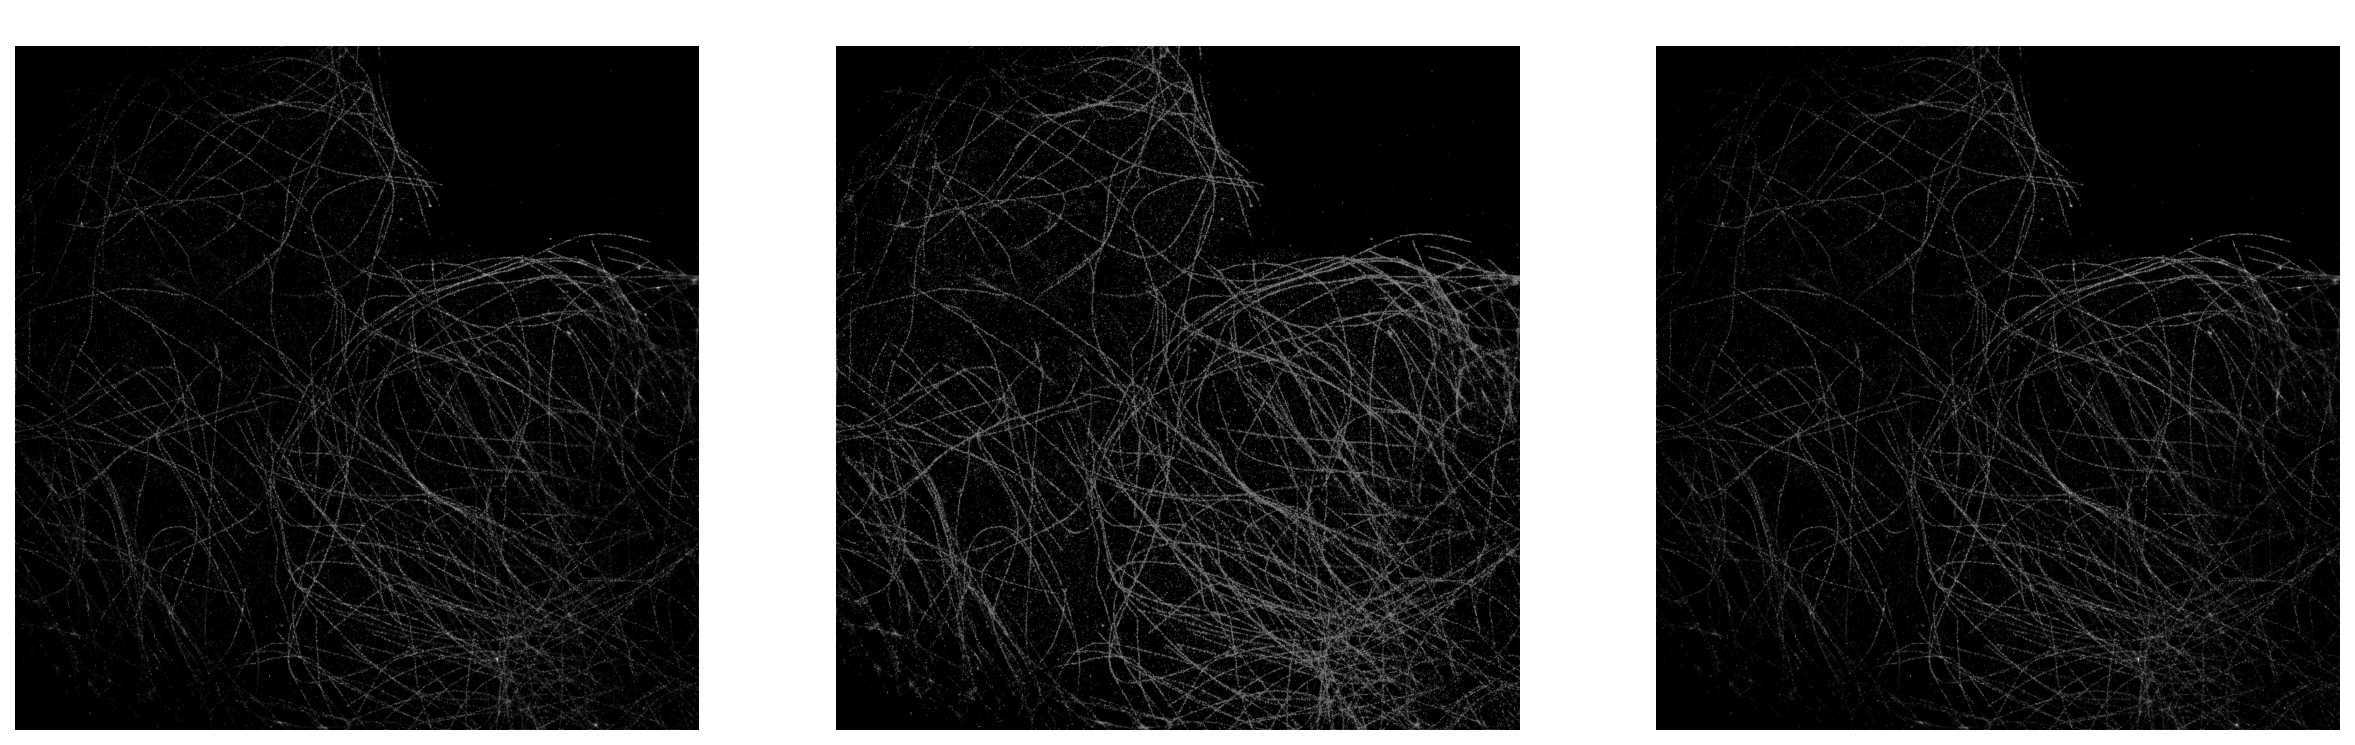

In [15]:
from Util.pyDialogue import askFILE
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

img = imread(askFILE())
fig, ax = plt.subplots(1,3, figsize=(20,10), dpi = 150)
ax[0].set_title('Original')
ax[0].imshow(img[...,0], cmap='gray')
ax[0].axis('off')

ax[1].set_title('Upscaled by 1k')
upscaled = img[...,0]*1000
ax[1].imshow(upscaled, cmap='gray')
ax[1].axis('off')

ax[2].set_title('Standardized/ Whitening')
whitened = (img[...,0]-np.mean(img[...,0]))/np.std(img[...,0])
ax[2].imshow(whitened, cmap='gray')
ax[2].axis('off')


print(f"Shape of the Original: {img.shape}")
print()
print('Original Image: ')
print(f"Intensity values range from {img.min()} to {img.max()}")
print()
print('Upscaled Image: ')
print(f"Intensity values range from {upscaled.min()} to {upscaled.max()}")
print()
print("Whitened Image: ")
print(f"Intensity values range from {whitened.min()} to {whitened.max()}")
print(f"Mean: {np.mean(whitened)}\tStd: {np.std(whitened)}")

Please pick an image to segment!
Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

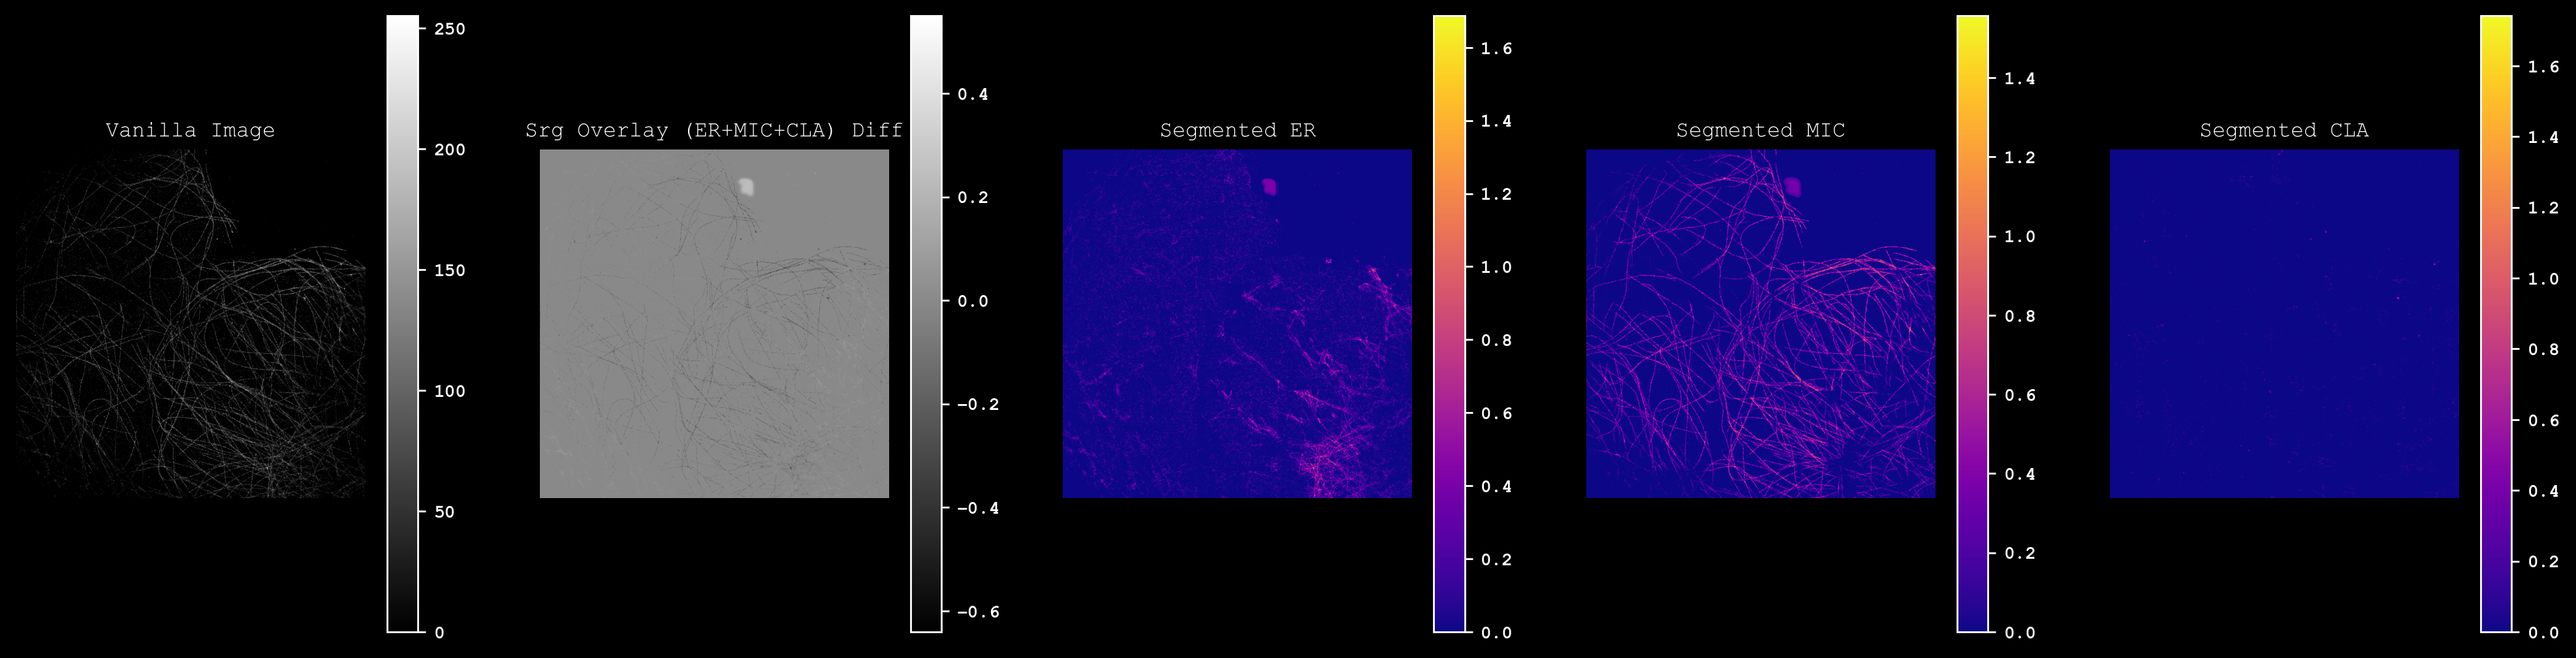

In [14]:
from Segment_torch import Segment_Image

Segment_Image(IMG_path = '', 
              patchsize = (256,256), 
              predictor = net, 
              th_ER= 0.1, 
              th_MIC = 0.1,
              th_CLA = 0.0,
              lower_dyn_th = -2,
              upper_dyn_th = 3,
              device = torch.device("cuda"),
              activation = torch.nn.Identity(),
              normalize = False,
              image_overview=True, 
              standardize = True, 
              save_predictions=False)

In [ ]:
from Util.pyDialogue import askFILE
import numpy as np

img = np.load(askFILE())
img.shape

In [ ]:
from skimage.io import imread
img = imread(askFILE())

In [ ]:
from Segment_torch import Segment_SMLM

Segment_SMLM(IMG_path = '', patchsize = (256,256), predictor = net, MIC_threshold= 0.1, LNP_threshold = 0.1, ACT_threshold = 0.1, lower_dyn_th = -2, upper_dyn_th = 3, device = torch.device("cuda"), activation = torch.nn.Identity(), plot_results = True, bin_diff=True, evaluate = False, standardize = True, plot_two_channel_images=True)

In [ ]:
import glob
from tqdm.notebook import tqdm
from Segment_torch import Segment_SMLM

for file in tqdm(glob.glob('../../../Paper Prep/Wuerzburg/TrainTestVal/test_mix/*.npy')):
    Segment_SMLM(IMG_path = file, patchsize = (256,256), predictor = net, MIC_threshold= 0.1, LNP_threshold = 0.1, ACT_threshold = 0.0, lower_dyn_th = -2, upper_dyn_th = 3, device = torch.device("cuda"), activation = torch.nn.Identity(), plot_results = False, bin_diff=False, evaluate = False, standardize = True, plot_two_channel_images=False, save_predictions=True, out_path='../../../Paper Prep/Wuerzburg/Test_prediction')

In [ ]:
from Segment_torch import Segment_SMLM

Segment_SMLM(IMG_path = '', patchsize = (256,256), predictor = net, MIC_threshold= 0.1, LNP_threshold = 0.1, ACT_threshold = 0.0, lower_dyn_th = -2, upper_dyn_th = 3, device = torch.device("cuda"), activation = torch.nn.Identity(), plot_results = True, bin_diff=True, evaluate = False, standardize = True, plot_two_channel_images=True, save_predictions = False)

In [8]:
import glob
from tqdm.notebook import tqdm
from Segment_torch import Segment_Image

for file in tqdm(glob.glob('../../../Paper Prep/Data_additional/Density_proxy/grays/*.png')):
    Segment_Image(IMG_path = file, 
                  patchsize = (256,256),
                  predictor = net,
                  th_ER= 0.1, 
                  th_MIC = 0.1, 
                  th_CLA = 0.0,
                  lower_dyn_th = -2,
                  upper_dyn_th = 3,
                  device = torch.device("cuda"), 
                  activation = torch.nn.Identity(), 
                  normalize = False, 
                  standardize = True,
                  save_predictions=True,
                  out_path='../../../Paper Prep/Data_additional/Density_proxy/grays/predictions_WU')

  0%|          | 0/14 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

Image has shape (3392, 3392) and is going to be cut into 169 pieces of shape (256, 256).


Predicting...:   0%|          | 0/169 [00:00<?, ?it/s]

In [ ]:
from Segment_torch import Segment_Image

Segment_Image(IMG_path = '', patchsize = (256,256), predictor = net, 
              th_ER = 0.1, th_MIC = 0.1, th_CLA = 0.0, device = torch.device("cuda"), 
              lower_dyn_th = -1, upper_dyn_th = 2, activation = torch.nn.Identity(), 
              test_zero = False, 
              ER_DIL_PRE = None, kernel_size = (2,2), iter = 1, return_imgs = False, revert = False, 
              normalize = False, standardize = True, save_predictions = False, filename = None, out_path = None) #-np.infty

In [ ]:
from Segment_torch import Segment_Image

Segment_Image('', (128,128), net,th_ER = 0.0, th_MIC = 0.0, th_CLA=0.0,lower_dyn_th=-1, upper_dyn_th = 2, test_zero=False, normalize=False, standardize=True) #-np.infty